`page 299`

# Chapter 7

## Exercise 6

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
import patsy

In [2]:
# debugging with birdseye
%load_ext birdseye

In [3]:
wage = sm.datasets.get_rdataset('Wage', package='ISLR').data
wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [4]:
# Reshape to get a vector
X = wage['age'].values.reshape(-1, 1)
y = wage['wage'].values.reshape(-1, 1)

In [28]:
# Polynomial regression over a range of degrees of freedom

scores = []
for i in range(1, 11):
    pipeline = Pipeline([('polynomial', PolynomialFeatures(degree=i)), 
                         ('linear', LinearRegression())]).fit(X, y)
    
    score = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    scores.append(np.mean(score))
    
scores = np.abs(scores)

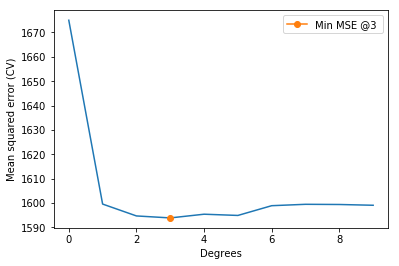

In [47]:
minimum = 'Min MSE @{} '.format(np.argmin(scores))

plt.plot(np.arange(0, 10), scores)
plt.plot(np.argmin(scores), min(scores), marker='o', label=minimum)
plt.ylabel('Mean squared error (CV)')
plt.xlabel('Degrees')
plt.legend()
plt.show()

### **Hypothesis testing with ANOVA**

In [49]:
# Statsmodels more convenient for ANOVA
models = []
for i in range(0, 11):
    poly = PolynomialFeatures(degree=i)
    X_poly = poly.fit_transform(X)
    model = sm.GLS(y, X_poly).fit()
    models.append(model)

In [67]:
print(sm.stats.anova_lm(models[0], models[1], models[2], models[3], models[4], models[5], 
                        models[6], models[7], models[8], models[9], models[10], typ=1))

    df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0     2999.0  5.222086e+06      0.0            NaN         NaN           NaN
1     2998.0  5.022216e+06      1.0  199869.664970  125.379287  1.536170e-28
2     2997.0  4.793430e+06      1.0  228786.010128  143.518661  2.449924e-32
3     2996.0  4.777674e+06      1.0   15755.693664    9.883629  1.683871e-03
4     2995.0  4.771604e+06      1.0    6070.152124    3.807838  5.110635e-02
5     2994.0  4.770322e+06      1.0    1282.563017    0.804558  3.698061e-01
6     2993.0  4.766389e+06      1.0    3932.257608    2.466726  1.163856e-01
7     2993.0  4.764599e+06     -0.0    1790.520215        -inf           NaN
8     2993.0  4.764136e+06     -0.0     462.421291        -inf           NaN
9     2993.0  4.764981e+06     -0.0    -844.190081         inf           NaN
10    2993.0  4.771202e+06     -0.0   -6221.351745         inf           NaN


We seek to determine the simplest model that is sufficient to explain the relationship between `wage` and `age`. The ANOVA test above shows that for degrees of freedom $> 3$, the $p$-value becomes more and more insignificant. $p$-values for models with degrees of freedom $< 3$ are close to zero, indicating that both linear and quadratic fits are not sufficient. In this data, Cubic and quartic models best fit the data. This is consistent with results from the cross validation approach.

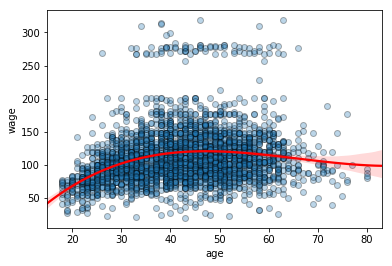

In [90]:
fig, ax = plt.subplots()
ax.scatter(X, y, facecolor=None, edgecolor='k', alpha=0.3)
sns.regplot('age', 'wage', data=wage, order=3, scatter=False, line_kws={'color': 'red'}, ax=ax)

### **Generalized logistic regression**

In [130]:
# Encode the response
y_new = (wage['wage'] > 250).map({False:0, True:1}).values

# polynomials of original X
X4 = X_test = PolynomialFeatures(degree=3).fit_transform(X)

# R-style logistic regression
logistic_model = sm.GLM(y_new, X4, family=sm.families.Binomial(sm.families.links.logit)).fit()

# Create sorted array of "age" for prediction
age_grid = np.arange(y.min(), y.max()).reshape(-1, 1) #shouldn't it be X.min(), X.max()
X_test = PolynomialFeatures(degree=3).fit_transform(age_grid)

# get predictions
preds = logistic_model.predict(X_test)

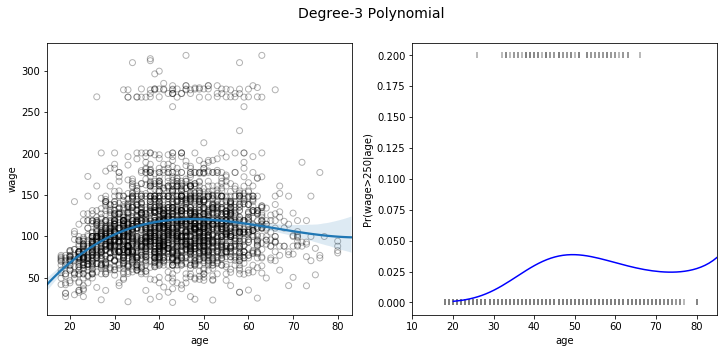

In [152]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Degree-3 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(X, y, facecolor='None', edgecolor='k', alpha=0.3)
sns.regplot('age', 'wage', data=wage, order=3, scatter=False, ax=ax1)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, preds, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(X, y_new/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlim(10, 85)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

In [153]:
print(logistic_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -353.96
Date:                Tue, 19 Feb 2019   Deviance:                       707.92
Time:                        14:54:57   Pearson chi2:                 2.82e+03
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.1342      6.665     -2.571      0.010     -30.198      -4.070
x1             0.7251      0.429      1.691      0.0

Note that in logistic regression, **deviance** is the proper measure of the model fit.

### **Step function**

I used [this](https://botlnec.github.io/islp/sols/chapter7/exercise6/) (part b) to first find the optimal number of cuts that minimize the MSE:

In [223]:
scores = []
for i in range(1, 11):
    age_groups = pd.cut(wage['age'], i)
    df_dummies = pd.get_dummies(age_groups)
    
    model = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression())])
    model.fit(df_dummies, y)
    score = cross_val_score(model, df_dummies, y, cv=5, scoring='neg_mean_squared_error')
    scores.append(np.mean(-score))

Text(0, 0.5, 'Mean Squared Error (MSE)')

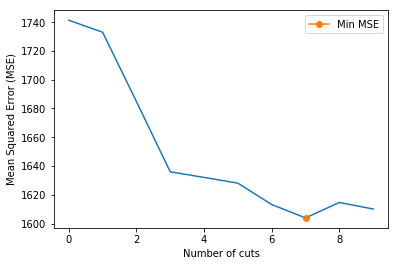

In [233]:
plt.plot(scores)
plt.plot(np.argmin(scores), min(scores), marker='o', label='Min MSE')
plt.legend()
plt.xlabel('Number of cuts')
plt.ylabel('Mean Squared Error (MSE)')

In [228]:
for i in range(0, len(scores)):
    print('Number of cuts: %i, error %.3f' % (i+1, scores[i]))

Number of cuts: 1, error 1741.335
Number of cuts: 2, error 1733.020
Number of cuts: 3, error 1684.811
Number of cuts: 4, error 1635.952
Number of cuts: 5, error 1632.038
Number of cuts: 6, error 1628.037
Number of cuts: 7, error 1613.187
Number of cuts: 8, error 1603.883
Number of cuts: 9, error 1614.631
Number of cuts: 10, error 1610.067


In [244]:
# seeing that 8 number of cuts gives the lowest MSE...
age_groups, bins = pd.cut(wage['age'], bins=8, retbins=True)
age_groups.value_counts(sort=False)

(17.938, 25.75]    231
(25.75, 33.5]      519
(33.5, 41.25]      671
(41.25, 49.0]      728
(49.0, 56.75]      503
(56.75, 64.5]      276
(64.5, 72.25]       54
(72.25, 80.0]       18
Name: age, dtype: int64

In [341]:
# Create dummy variables out of age groups and drop the last column
# drop one column of dummy vars is important
age_dummies = pd.get_dummies(age_groups).iloc[:,:-1]   # just set drop_first=True
age_dummies.head()

,"(17.938, 25.75]","(25.75, 33.5]","(33.5, 41.25]","(41.25, 49.0]","(49.0, 56.75]","(56.75, 64.5]","(64.5, 72.25]"
231655,1,0,0,0,0,0,0
86582,1,0,0,0,0,0,0
161300,0,0,0,1,0,0,0
155159,0,0,0,1,0,0,0
11443,0,0,0,0,1,0,0


In [374]:
# With statsmodels, need to manually add constant (intercept)
age_dummies = sm.add_constant(age_dummies)

# linear regression with steps determined by bins
linear_model = sm.GLM(y, age_dummies).fit()
print(linear_model.summary().tables[1])

                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              91.5059      9.421      9.713      0.000      73.041     109.971
(17.938, 25.75]   -15.2242      9.781     -1.556      0.120     -34.395       3.946
(25.75, 33.5]      10.6091      9.583      1.107      0.268      -8.173      29.391
(33.5, 41.25]      25.0015      9.546      2.619      0.009       6.291      43.712
(41.25, 49.0]      28.2769      9.537      2.965      0.003       9.585      46.969
(49.0, 56.75]      24.9116      9.588      2.598      0.009       6.119      43.704
(56.75, 64.5]      28.8782      9.723      2.970      0.003       9.821      47.936
(64.5, 72.25]      13.7241     10.878      1.262      0.207      -7.597      35.045


In [380]:
# logistic regression with steps determined by bins
logistic_model = sm.GLM(y, age_dummies, family=sm.families.Binomial(sm.families.links.logit)).fit()
print(logistic_model.summary().tables[1])

                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.125e+17   1.58e+07   3.87e+10      0.000    6.13e+17    6.13e+17
(17.938, 25.75] -1.028e+17   1.64e+07  -6.26e+09      0.000   -1.03e+17   -1.03e+17
(25.75, 33.5]    7.167e+16   1.61e+07   4.45e+09      0.000    7.17e+16    7.17e+16
(33.5, 41.25]    1.689e+17    1.6e+07   1.05e+10      0.000    1.69e+17    1.69e+17
(41.25, 49.0]     1.91e+17    1.6e+07   1.19e+10      0.000    1.91e+17    1.91e+17
(49.0, 56.75]    1.683e+17   1.61e+07   1.05e+10      0.000    1.68e+17    1.68e+17
(56.75, 64.5]    1.951e+17   1.63e+07   1.19e+10      0.000    1.95e+17    1.95e+17
(64.5, 72.25]    9.271e+16   1.83e+07   5.08e+09      0.000    9.27e+16    9.27e+16


In [370]:
# create a test set (practically) with equal bins as the original
bin_mapping = np.digitize(age_grid.ravel(), bins)
bin_mapping

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtyp

In [377]:
bin_mapping = pd.get_dummies(bin_mapping).iloc[:, :-2]
bin_mapping = sm.add_constant(bin_mapping)
bin_mapping.head()

,const,1,2,3,4,5,6,7
0,1.0,1,0,0,0,0,0,0
1,1.0,1,0,0,0,0,0,0
2,1.0,1,0,0,0,0,0,0
3,1.0,1,0,0,0,0,0,0
4,1.0,1,0,0,0,0,0,0


In [381]:
# make predictions
X_test = bin_mapping.copy()

# linear regression
linear_preds = linear_model.predict(X_test)

#logistic_regression
logistic_preds = logistic_model.predict(X_test)

Text(0, 0.5, 'wage')

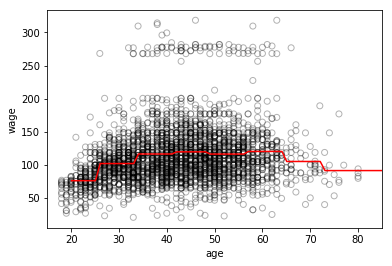

In [412]:
# Scatter plot with polynomial regression line
plt.scatter(X, y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(age_grid, linear_preds, c='r')
plt.xlim(15, 85)
plt.xlabel('age')
plt.ylabel('wage')

***
## Exercise 9

In [415]:
boston = sm.datasets.get_rdataset('Boston', package='MASS').data
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


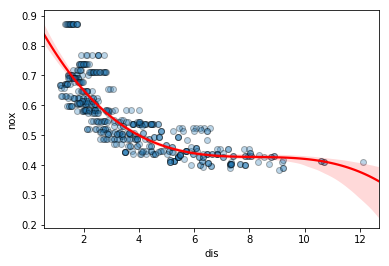

In [419]:
fig, ax = plt.subplots()
ax.scatter(boston['dis'], boston['nox'], facecolor=None, edgecolor='k', alpha=0.3)
sns.regplot('dis', 'nox', data=boston, order=3, scatter=False, line_kws={'color': 'red'}, ax=ax)

### **Splines**

For splines, we can use Patsy library, which allows us define R-style formulas:

In [454]:
#range of values in "dis"
boston['dis'].min(), boston['dis'].max()

(1.1296, 12.1265)

We can now specify knots of the splines, e.g. 4, 7, and 10.

In [463]:
from patsy import dmatrix

# Define the bs() function
spline_basis = dmatrix('bs(dis, knots=(4, 7, 10), include_intercept=False)',
                      {'dis': boston['dis']}, return_type='dataframe')


# fit to sm.glm
spline_fit = sm.GLM(boston['nox'], spline_basis).fit()

print(spline_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    nox   No. Observations:                  506
Model:                            GLM   Df Residuals:                      499
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                       0.0038253
Method:                          IRLS   Log-Likelihood:                 693.77
Date:                Tue, 19 Feb 2019   Deviance:                       1.9088
Time:                        21:51:08   Pearson chi2:                     1.91
No. Iterations:                     3   Covariance Type:             nonrobust
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                    

## $Fin$

> skipped more than few questions in this chapter because pretty boring